<a href="https://colab.research.google.com/github/j-buss/wi-dpi-analysis/blob/development/eda/5.0_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Salary and Education in Wisconsin - 5.0 Analysis

### Prep

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

In [0]:
%matplotlib inline
plt.style.use('bmh')



### Functions



In [0]:
# To help with the pie charts later
def make_autopct(values):
  def my_autopct(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{p:.2f}% \n({v:,d})'.format(p=pct,v=val)
  return my_autopct

### Processing

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id='wi-dpi-010'
landing_dataset_name='landing'
refined_dataset_name='refined'
gold_dataset_name='gold'

In [0]:
bq_client = bigquery.Client(project=project_id)

# Analysis

Would like to explore


*   Experience level
*   Turnover rate
*    Standardized Test Performance
*    Demographics
*    Staffing Levels
*    Salary



Maybe one of the most interesting areas to explore is Salary...

## Explore Salaries

Let's take the most recent information and analyze the breakdown of salary

In [0]:
sql='''
  SELECT
    *
  FROM
    {}.{}
'''.format('refined','2017_all_staff_report')

In [8]:
df = pd.read_gbq(sql, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187344 entries, 0 to 187343
Data columns (total 57 columns):
research_id                          187344 non-null int64
year_session                         187344 non-null int64
first_name                           187344 non-null object
last_name                            187344 non-null object
entity_id                            142718 non-null object
gender                               187344 non-null object
race_ethnicity_cd                    187344 non-null object
race_ethnicity_desc                  187344 non-null object
birth_year                           187344 non-null int64
contract_hire_agency_cd              107926 non-null object
contract_hire_agency_desc            107926 non-null object
contract_high_degree_cd              107898 non-null object
contract_high_degree_desc            107898 non-null object
contract_days                        107926 non-null object
contract_local_experience            107926 non-null

In [0]:
values = {'salary': 0}
df.fillna(value=values, inplace=True)

In [11]:
df['salary']

0         108840.0
1         118000.0
2          92000.0
3         158162.0
4         120082.0
5         109629.0
6          85000.0
7         136331.0
8         145550.0
9         112000.0
10        150000.0
11        185000.0
12        124258.0
13        116000.0
14        145030.0
15        147354.0
16        108909.0
17        121540.0
18        135971.0
19        125000.0
20        114175.0
21        147802.0
22        114000.0
23        121000.0
24        120000.0
25        135000.0
26        145000.0
27        133429.0
28        159730.0
29        140355.0
30        142783.0
31         58500.0
32        145664.0
33        106575.0
34        119000.0
35        128353.0
36        101500.0
37        112200.0
38        122000.0
39        100000.0
40         67000.0
41        129666.0
42        128530.0
43        126896.0
44        134052.0
45        187862.0
46        172195.0
47        102000.0
48        131684.0
49         98000.0
            ...   
187294         0.0
187295      

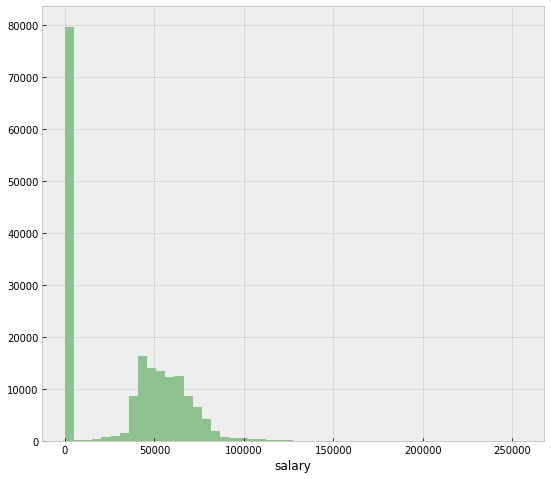

In [15]:
plt.figure(figsize=(9, 8))
sns.distplot(df['salary'], color='g', kde=False )
#plt.hist(df['salary'],bins=100)

### Why are there $0 salaries?

While there are well meaning individuals working in the school districts the picture does not point to all the individuals that volunteer. This data is for paid workers in the school districts. However what we are seeing is the number of individuals that are paid hourly, and therefore they are not under contract with the districts. As a result those salaries are not listed in the file.

In [0]:
records_w_o_salary = df['salary'][df['salary']==0].count()
records_w_salary = df['salary'][df['salary']!=0].count()
total_records = df['salary'].count()

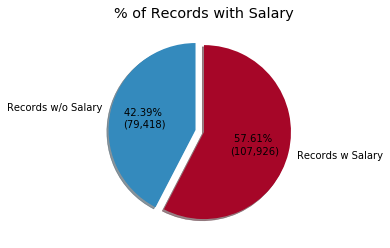

In [17]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Records w/o Salary', 'Records w Salary']
values = [records_w_o_salary, records_w_salary]
explode = (0.1, 0)


#fig1, ax1 = plt.subplots()
#ax1.pie(sizes, explode=explode, labels=labels, autopct=make_autopct(values),
#        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('% of Records with Salary')
plt.pie(values, explode=explode, labels=labels, autopct=make_autopct(values),
       shadow=True, startangle=90)
plt.show()

In [0]:
#Same analysis but with SQL to verify
sql_salary_summary ='''
  SELECT
    sum(a.no_salary) as count_no_salary,
    sum(a.has_salary) as count_has_salary,
    count(*) as count_total_record
  FROM
    (SELECT
      CASE WHEN (salary = 0 OR salary is null) THEN 1
      ELSE 0
      END AS no_salary,
      CASE WHEN (salary <> 0 AND salary is not null) THEN 1
      ELSE 0
      END as has_salary
    FROM
      `wi-dpi-010.refined.2015_all_staff_report`) a
'''

So we see there there are a number of records that have $0 Salaries. However we need to understand what we are looking at. Each of the records is not a person, but an allocation of a role.

In [0]:
sql_role_cat_w_salary_2017 = '''
SELECT
  A.assignment_staff_category_desc,
  A.position_classification,
  sum(has_salary) Salary,
  sum(has_contract) Contract,
  sum(no_salary) No_Salary,
  sum(no_contract) No_Contract
FROM
(SELECT
    assignment_staff_category_desc,
    position_classification,
    CASE WHEN (salary = 0 OR salary is null) THEN 1
    ELSE 0
    END AS no_salary,
    CASE WHEN (salary <> 0 AND salary is not null) THEN 1
    ELSE 0
    END as has_salary,
    CASE WHEN (contract_days = 0 OR contract_days is null) THEN 1
    ELSE 0
    END AS no_contract,
    CASE WHEN (contract_days <> 0 AND contract_days is not null) THEN 1
    ELSE 0
    END as has_contract
  FROM
    {}.{}) A
GROUP BY
  A.assignment_staff_category_desc,
  A.position_classification
'''.format('refined','2017_all_staff_report')

In [24]:
df_role_cat_w_salary_2017 = pd.read_gbq(sql_role_cat_w_salary_2017, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [0]:
sql_role_cat_w_salary_2015 = '''
SELECT
  A.staff_category_desc,
  A.position_description,
  A.position_type_cd,
  sum(has_salary) Salary,
  sum(has_contract) Contract,
  sum(no_salary) No_Salary,
  sum(no_contract) No_Contract
FROM
  (SELECT
    staff_category_desc,
    position_description,
    position_type_cd,
    CASE WHEN (salary = 0 OR salary is null) THEN 1
    ELSE 0
    END AS no_salary,
    CASE WHEN (salary <> 0 AND salary is not null) THEN 1
    ELSE 0
    END as has_sala
    CASE WHEN (contract_days = 0 OR contract_days is null) THEN 1
    ELSE 0
    END AS no_contract,
    CASE WHEN (contract_days <> 0 ANCD contract_days is not null) THEN 1
    ELSE 0
    END as has_contract
  FROM
    {}.{}) A
GROUP BY
  A.staff_category_desc,
  A.position_description,
  A.position_type_cd
'''.format('refined','2015_all_staff_report')

In [21]:
df_role_cat_w_salary_2015 = pd.read_gbq(sql_role_cat_w_salary_2015, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [26]:
df_role_cat_w_salary_2017[['A_assignment_staff_category_desc','Salary','No_Salary']]\
  .groupby('A_assignment_staff_category_desc').sum().sort_values(
  by=['Salary','No_Salary'],
  ascending=False)

,Salary,No_Salary
A_assignment_staff_category_desc,,
Professional,93943,1442
Short-Term Sub/Extra Curricular Activities,7188,18999
Support,6795,58977


Adding in some inforamtion about contracts we see that the two are corelated:

In [28]:
df_role_cat_w_salary_2017\
  .groupby('A_assignment_staff_category_desc').sum().sort_values(
  by=['Salary','No_Salary'],
  ascending=False)

,Salary,Contract,No_Salary,No_Contract
A_assignment_staff_category_desc,,,,
Professional,93943,93943,1442,1442
Short-Term Sub/Extra Curricular Activities,7188,7188,18999,18999
Support,6795,6795,58977,58977


Generally speaking the roles either display Salary information or not. There do seem to be a few exceptions to this rule. Analyzing the data in a bit more detail we filter on a few positions which seem to have some split. The majority being Salary/Contract, but a small percentage being No-Salary/No-Contract.

In [33]:
df_role_cat_w_salary_2017.sort_values(['Salary','No_Salary'],ascending=False)
#result = df.sort(['A', 'B'], ascending=[1, 0])

,A_assignment_staff_category_desc,A_position_classification,Salary,Contract,No_Salary,No_Contract
3,Professional,Teachers,79353,79353,1068,1068
5,Professional,Pupil Services,7242,7242,249,249
2,Short-Term Sub/Extra Curricular Activities,Other,7002,7002,4818,4818
0,Support,Other,6724,6724,38758,38758
4,Professional,Administrators,5248,5248,60,60
6,Professional,Other,2100,2100,65,65
7,Short-Term Sub/Extra Curricular Activities,None,158,158,12616,12616
1,Support,Aides / Paraprofessionals,71,71,20213,20213
8,Short-Term Sub/Extra Curricular Activities,Aides / Paraprofessionals,28,28,1565,1565
9,Support,Teachers,0,0,6,6


SHOULD WE ADD AN AVERAGE SALARY BY POSITION

Summary: Roles tend to have Salary information or not.

### How many people have a salary?

The previous analysis started by examining salary data. What we found is that there are a number records in the data set that do not show salary data as these roles do not have a contract. We filtered the data out to find some information about the roles that were under contract and therefore had a salary. 

For this step, as we want to go deeper into the Salary data we still need to answer the question about people.

How many people in the dataset?

In [0]:
total_parties = df['research_id'].nunique()
parties_w_salary = df[df['salary']!=0].groupby(['research_id'])['salary'].max().count()
parties_w_o_salary = df[df['salary']==0].groupby(['research_id'])['salary'].max().count()

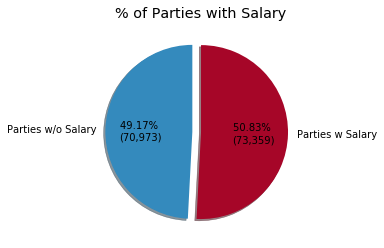

In [35]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Parties w/o Salary', 'Parties w Salary']
values = [parties_w_o_salary, parties_w_salary]
explode = (0.1, 0)


#fig1, ax1 = plt.subplots()
#ax1.pie(sizes, explode=explode, labels=labels, autopct=make_autopct(values),
#        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('% of Parties with Salary')
plt.pie(values, explode=explode, labels=labels, autopct=make_autopct(values),
       shadow=True, startangle=90)
plt.show()

This data has been saved into the gold.party_w_salary table.

In [0]:
sql='''
  SELECT
    *
  FROM
    {}.{}
'''.format('gold','party_w_salary')

In [0]:
df_party_w_salary = pd.read_gbq(sql, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [0]:
df_party_w_salary = df[df['salary']!=0]

In [37]:
df_party_w_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107926 entries, 0 to 187343
Data columns (total 57 columns):
research_id                          107926 non-null int64
year_session                         107926 non-null int64
first_name                           107926 non-null object
last_name                            107926 non-null object
entity_id                            107216 non-null object
gender                               107926 non-null object
race_ethnicity_cd                    107926 non-null object
race_ethnicity_desc                  107926 non-null object
birth_year                           107926 non-null int64
contract_hire_agency_cd              107926 non-null object
contract_hire_agency_desc            107926 non-null object
contract_high_degree_cd              107898 non-null object
contract_high_degree_desc            107898 non-null object
contract_days                        107926 non-null object
contract_local_experience            107926 non-null

In [0]:
sns.distplot(df_party_w_salary['sal'],kde=False, norm_hist=True)

KeyError: ignored

### What are the factors that affect salary?

We see with the histogram that there is a bi-modal distribution.

What are some things that would affect it?



1.   Teachers vs. Administrators
2.   List item



#### Can someone be a teacher and an administrator?

Yes. There are 509 parties that are playing a role as an administrator, in addition to either a support position or licensed position.

In [0]:
SELECT
    a.id_nbr,
    a.position_type_cd as a_pos_typ,
    b.position_type_cd as b_pos_typ
  FROM 
    `wi-dpi-010.refined.2015_all_staff_report` a INNER JOIN
    `wi-dpi-010.refined.2015_all_staff_report` b ON
    (a.id_nbr = b.id_nbr and a.position_type_cd != b.position_type_cd)
  WHERE
    a.position_type_cd = 'A'

IndentationError: ignored

Just do analysis with 1.0 FTEs

Then "pro-rate" the salary based on FTE %



In [0]:
#Characteristics of the individual: Age, Experience, Gender, RaceEthnicity,
#Characteristics of their roles: FTE, Number of Roles, Teacher/Administrator, Subject, School, Cesa
#Create Linear Regression to predict the Salary of an individual

## Regression

### version 1

For the first version of the regression we will select only the individuals that have a salary; and only the records where the assignment is 100%. This will limit much of the variability, but again this is just our first version of the linear regression model.

In [0]:
regression_v1_select = '''
SELECT
  research_id,
  gender,
  race_ethnicity_cd,
  birth_year,
  contract_high_degree_cd,
  contract_days,
  contract_local_experience,
  contract_total_experience,
  cesa_num,
  assignment_fte,
  assignment_requires_dpi_license,
  assignment_staff_category_cd,
  position_classification,
  assignment_position_cd,
  assignment_area_cd,
  assignment_work_school_level_cd,
  salary
FROM
  {}.{}
WHERE
  assignment_fte = 1 and salary is not null
'''.format(refined_dataset_name, '2017_all_staff_report')

In [52]:
df_v1_regression = pd.read_gbq(regression_v1_select, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [53]:
df_v1_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55633 entries, 0 to 55632
Data columns (total 17 columns):
research_id                        55633 non-null int64
gender                             55633 non-null object
race_ethnicity_cd                  55633 non-null object
birth_year                         55633 non-null int64
contract_high_degree_cd            55628 non-null object
contract_days                      55633 non-null int64
contract_local_experience          55633 non-null float64
contract_total_experience          55633 non-null float64
cesa_num                           55572 non-null object
assignment_fte                     55633 non-null float64
assignment_requires_dpi_license    55633 non-null object
assignment_staff_category_cd       55633 non-null object
position_classification            55633 non-null object
assignment_position_cd             55633 non-null object
assignment_area_cd                 55633 non-null object
assignment_work_school_level_cd    5



Break the dataframe by position_classification (Teacher, Administrator, Pupil Services, Other)



In [0]:
df_v1_regression_teachers = df_v1_regression[df_v1_regression['position_classification']=='Teachers']

In [0]:
df_v1_regression_administrators = df_v1_regression[df_v1_regression['position_classification']=='Administrators']

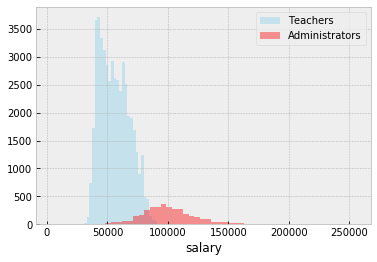

In [43]:
sns.distplot(df_v1_regression_teachers['salary'],color="skyblue", kde=False, label="Teachers")
sns.distplot(df_v1_regression_administrators['salary'],color="red", kde=False, label="Administrators")
plt.legend()
plt.show()

### Make some one-hot encoding

In [0]:
df_working = df_v1_regression

One Hot Encodings:

*   gender
*   ethnicity
*   contract_high_degree_cd
*   cesa_num
*   assignment_requires_dpi_license
*   assignment_staff_category_cd 
*   position_classification
*   assignment_position_cd 
*   assignment_area_cd 
*   assignment_work_school_level_cd



In [0]:

df_working = pd.concat([df_working.drop('gender', axis=1), pd.get_dummies(df['gender'],prefix='gender')], axis=1)

In [0]:

df_working = pd.concat([df_working.drop('race_ethnicity_cd', axis=1), pd.get_dummies(df['race_ethnicity_cd'],prefix='ethnicity')], axis=1)

In [0]:
df_working = pd.concat([df_working.drop('contract_high_degree_cd', axis=1), pd.get_dummies(df['contract_high_degree_cd'],prefix='degree')], axis=1)
df_working = pd.concat([df_working.drop('cesa_num', axis=1), pd.get_dummies(df['cesa_num'],prefix='cesa')], axis=1)
df_working = pd.concat([df_working.drop('assignment_staff_category_cd', axis=1), pd.get_dummies(df['assignment_staff_category_cd'],prefix='assignment_staff_category_cd')], axis=1)
df_working = pd.concat([df_working.drop('position_classification', axis=1), pd.get_dummies(df['position_classification'])], axis=1)

In [60]:
df_working

,research_id,birth_year,contract_days,contract_local_experience,contract_total_experience,assignment_fte,assignment_requires_dpi_license,assignment_position_cd,assignment_area_cd,assignment_work_school_level_cd,salary,gender_F,gender_M,ethnicity_A,ethnicity_B,ethnicity_H,ethnicity_I,ethnicity_P,ethnicity_T,ethnicity_W,degree_3,degree_4,degree_5,degree_6,degree_7,degree_8,cesa_1,cesa_2,cesa_3,cesa_4,cesa_5,cesa_6,cesa_7,cesa_8,cesa_9,cesa_10,cesa_11,cesa_12,assignment_staff_category_cd_0,assignment_staff_category_cd_1,assignment_staff_category_cd_2,assignment_staff_category_cd_3,assignment_staff_category_cd_4,Administrators,Aides / Paraprofessionals,Other,Pupil Services,Teachers
0,39787.0,1981.0,215.0,2.0,2.0,1.0,Y,51,0000,3,102587.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,16230.0,1987.0,215.0,2.0,2.0,1.0,Y,51,0000,5,97668.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,138828.0,1969.0,188.0,2.0,2.0,1.0,Y,87,0000,None,40027.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,146690.0,1956.0,218.0,2.0,2.0,1.0,N,75,0000,None,47390.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,16983.0,1989.0,188.0,1.0,2.0,1.0,Y,54,0000,3,43500.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
5,144484.0,1957.0,261.0,2.0,2.0,1.0,Y,10,0000,None,98300.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
6,3007.0,1992.0,189.0,2.0,2.0,1.0,Y,54,0000,6,42000.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
7,11796.0,1986.0,188.0,2.0,2.0,1.0,N,75,0000,None,45000.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
8,38312.0,1966.0,194.0,2.0,2.0,1.0,Y,87,0000,None,60570.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
9,148294.0,1970.0,187.0,2.0,2.0,1.0,N,75,0000,None,47593.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
